In [1]:
import torch
from model import UNet
from dataset import RetinaDataset
from utils import load_data
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import albumentations as A

EXP_ID = 18749

CHECKPOINT_PATH = f'/scratch/y.aboelwafa/Retina/Retina_Blood_Vessel_Segmentation/checkpoints/checkpoint_{EXP_ID}.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1)
model.to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
summary(model, input_size=[1, 3, 512, 512])

/home/y.aboelwafa/.conda/envs/cv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 512, 512]          --
├─Sequential: 1-1                        [1, 64, 512, 512]         --
│    └─Conv2d: 2-1                       [1, 64, 512, 512]         1,792
│    └─ReLU: 2-2                         [1, 64, 512, 512]         --
│    └─Conv2d: 2-3                       [1, 64, 512, 512]         36,928
│    └─ReLU: 2-4                         [1, 64, 512, 512]         --
├─MaxPool2d: 1-2                         [1, 64, 256, 256]         --
├─Sequential: 1-3                        [1, 128, 256, 256]        --
│    └─Conv2d: 2-5                       [1, 128, 256, 256]        73,856
│    └─ReLU: 2-6                         [1, 128, 256, 256]        --
│    └─Conv2d: 2-7                       [1, 128, 256, 256]        147,584
│    └─ReLU: 2-8                         [1, 128, 256, 256]        --
├─MaxPool2d: 1-4                         [1, 128, 128, 128]        --

In [2]:
show_imgs = 5
test_transform = A.Compose(
    [
        A.Resize(512, 512),
    ]
)
train_images, train_masks, test_images, test_masks = load_data("dataset")
test_dataset = RetinaDataset(test_images, test_masks, transform=test_transform)

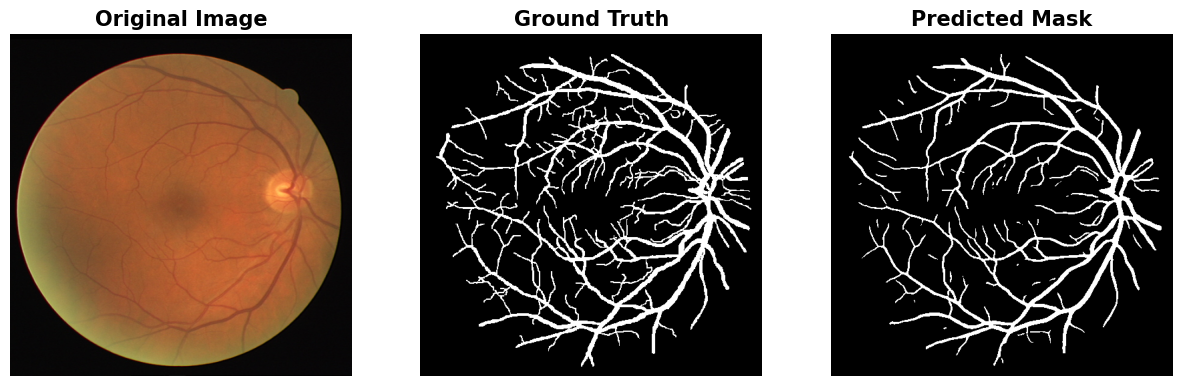

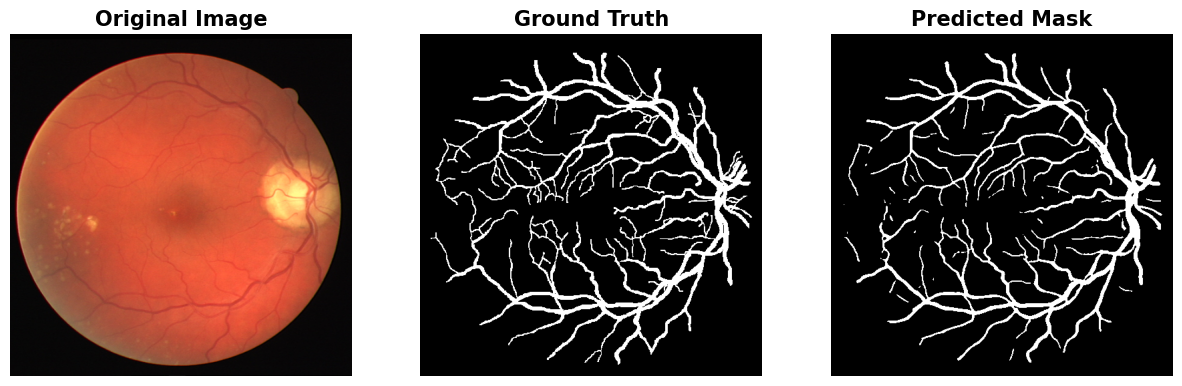

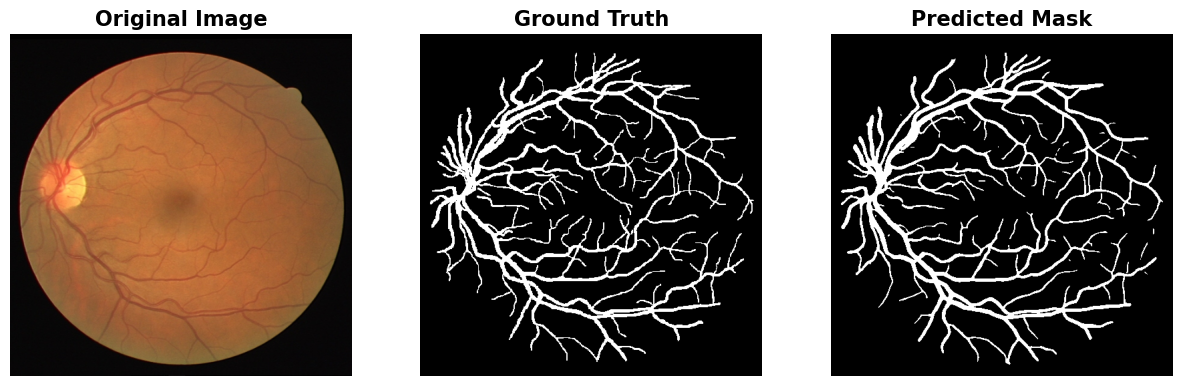

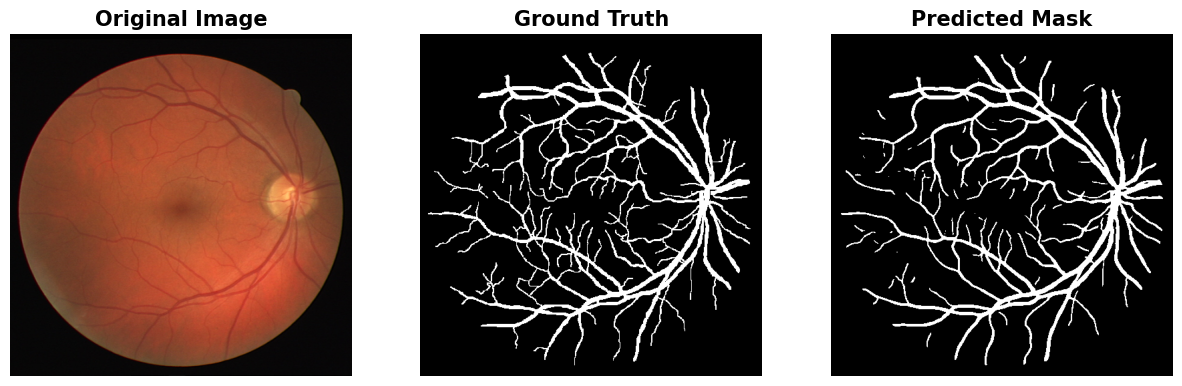

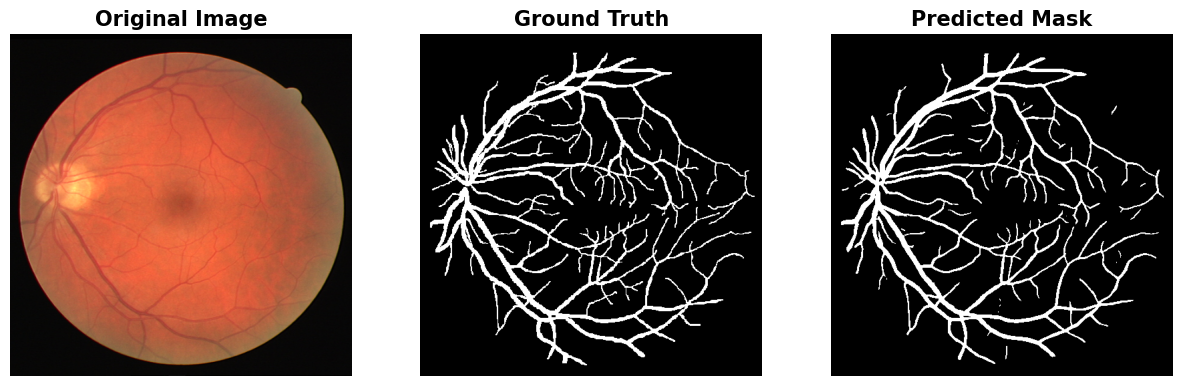

In [3]:
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)
for i in range(show_imgs):
    img, mask = test_dataset[random_list[i]]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    pred = model(img)
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img.squeeze().permute(1, 2, 0).numpy())
    ax[0].set_title("Original Image", fontsize=15, weight='bold')
    ax[0].axis('off')
    ax[1].imshow(mask.squeeze().numpy(), cmap='gray')
    ax[1].set_title("Ground Truth", fontsize=15, weight='bold')
    ax[1].axis('off')
    ax[2].imshow(pred.squeeze().numpy(), cmap='gray')
    ax[2].set_title("Predicted Mask", fontsize=15, weight='bold')
    ax[2].axis('off')
    plt.show()